### Exercise 6

#### choice of the order of Runge-Kuta method
change the "accuracy=" option in this line:
    vxs, vys = self.assign_velocities_to_markers(self.func_vx, self.func_vy, accuracy=4)
Note that dt is estimated using the time increment of the last step.

#### Continuity based interpolation

Note that this code has a bug where no marker is found near a node for a later time step

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
from scipy import sparse
import scipy.sparse.linalg
import random
from IPython import display
import time
ROOTDIR = '/home/lochy/Documents/Subject/ucd_geology/Gel298_winter/jupyter_notebooks'
sys.path.append('%s/python_scripts' % ROOTDIR)
import GMesh2d as GMsh
import GMarker as GMK

### Step 1: setup the mesh

In [2]:
# Numerical model parameters
g = 10.0  # grav acc
eta0 = 1e20 # viscosity for non-dimensionalization

#### Utility functions

In [3]:
year = 365 * 24 * 3600.0

def BilinearInterpolation(x, y, x0, x1, y0, y1, vs):
    '''
    Bilinear iterpolation of 4 points in a rectangular grid
    Inputs:
        x, y : point to interpolate
        x0, x1: x-dimention boundary of this cell
        yo, y1: y-dimention boundary of this cell
        vs: values on 4 points
    Returns:
        v_x_y: interpolated value on point
    '''
    assert(len(vs)==4)  # vs has 4 entries
    assert(x0<=x and x<=x1) # x,y are internal points
    assert(y0<=y and y<=y1)
    v_x_y0 = (x1 - x) / (x1 - x0) * vs[0] + (x - x0) / (x1 - x0) * vs[1]
    v_x_y1 = (x1 - x) / (x1 - x0) * vs[3] + (x - x0) / (x1 - x0) * vs[2]
    v_x_y = (y1 - y) / (y1 - y0) * v_x_y0 + (y - y0) / (y1 - y0) * v_x_y1
    return v_x_y

def plot_result(mesh, Solver, Marker):
    '''
    Plot result
    Note the velocity is plotted by either exporting the solution direction with coordinates or interpolating onto points.
    '''
    xs, ys = mesh.get_coordinates()
    xsize, ysize = mesh.get_sizes()
    # parse the outputs
    xx, yy = np.meshgrid(xs, ys)
    rhorho = Marker.export_densities()
    etaeta = Marker.export_viscosities()
    xxp, yyp, pp = Solver.parse_solution_P()
    xx_vx, yy_vx, vvx = Solver.parse_solution_Vx()
    xx_vy, yy_vy, vvy = Solver.parse_solution_Vy()
    vvx_interp = np.zeros(xx.shape)  # interpolate to uniform mesh
    vvy_interp = np.zeros(xx.shape)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            x = xx[i, j]
            y = yy[i, j]
            vvx_interp[i, j] = Solver.get_vx_staggered(x, y)
            vvy_interp[i, j] = Solver.get_vy_staggered(x, y)
    vv_magnitude_interp = (vvx_interp**2.0 + vvy_interp**2.0)**0.5
    time, step = Solver.get_time()
    # plot
    fig = plt.figure(tight_layout=True, figsize=(15, 10))
    gs = gridspec.GridSpec(2, 3)
    ax = fig.add_subplot(gs[0, 0])  # density
    h=ax.pcolormesh(xx/1e3, yy/1e3, rhorho)
    ax.set_xlim([0.0, xsize/1e3])
    ax.set_ylim([0.0, ysize/1e3])
    ax.set_xlabel('X (km)') 
    ax.set_ylabel('Y (km)')
    ax.invert_yaxis()
    fig.colorbar(h, ax=ax, label='Density (km/m^3)')
    ax = fig.add_subplot(gs[0, 1])  # viscosity
    h=ax.pcolormesh(xx/1e3, yy/1e3, np.log10(etaeta))
    ax.set_xlim([0.0, xsize/1e3])
    ax.set_ylim([0.0, ysize/1e3])
    ax.set_xlabel('X (km)') 
    ax.set_ylabel('Y (km)')
    ax.invert_yaxis()
    fig.colorbar(h, ax=ax, label='log(Viscosity) (Pa*s)')
    ax = fig.add_subplot(gs[0, 2]) # pressure
    h=ax.pcolormesh(xxp/1e3, yyp/1e3, pp/1e9)
    ax.set_xlim([0.0, xsize/1e3])
    ax.set_ylim([0.0, ysize/1e3])
    ax.set_xlabel('X (km)') 
    ax.set_ylabel('Y (km)')
    ax.invert_yaxis()
    fig.colorbar(h, ax=ax, label='Pressure (Gpa)')
    ax = fig.add_subplot(gs[1, 0]) # vx
    h=ax.pcolormesh(xx_vx/1e3, yy_vx/1e3, vvx)
    ax.set_xlim([0.0, xsize/1e3])
    ax.set_ylim([0.0, ysize/1e3])
    ax.set_xlabel('X (km)') 
    ax.set_ylabel('Y (km)')
    ax.invert_yaxis()
    fig.colorbar(h, ax=ax, label='Vx (m/s)')
    ax = fig.add_subplot(gs[1, 1])
    h=ax.pcolormesh(xx_vy/1e3, yy_vy/1e3, vvy)
    ax.set_xlim([0.0, xsize/1e3])
    ax.set_ylim([0.0, ysize/1e3])
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    ax.invert_yaxis()
    fig.colorbar(h, ax=ax, label='Vy (m/s)')
    ax = fig.add_subplot(gs[1, 2])  # quiver
    h=ax.pcolormesh(xx/1e3, yy/1e3, vv_magnitude_interp)
    ax.quiver(xx/1e3, yy/1e3, vvx_interp, vvy_interp, angles='xy')
    ax.set_xlim([0.0, xsize/1e3])
    ax.set_ylim([0.0, ysize/1e3])
    ax.set_xlabel('X (km)') 
    ax.set_ylabel('Y (km)')
    fig.colorbar(h, ax=ax, label='Magnitude of velocity (m/s)')
    ax.invert_yaxis()
    fig.suptitle('step = %d, t = %.4e yr' % (step, time/year))
    plt.savefig("figures_continuity_based/Stokes_Continuity_Markers_s%d.png" % step)


def PlotMarkerIndexes(Marker):
    '''
    Plot the indexes of markers
    '''
    xms, yms, ids = Marker.get_markers()
    xsize, ysize = Marker.mesh.get_sizes()
    fig = plt.figure(tight_layout=True, figsize=(5, 5))
    ax = fig.add_subplot()  # index
    colors = ['c', 'r']
    h=ax.scatter(xms/1e3, yms/1e3, c=[colors[id] for id in ids])
    ax.set_xlim([0.0, xsize/1e3])
    ax.set_ylim([0.0, ysize/1e3])
    ax.set_xlabel('X (km)') 
    ax.set_ylabel('Y (km)')
    ax.invert_yaxis()

def plot_P_node_velocity(Solver):
    '''
    Export and plot velocity on P nodes
    '''
    xxp, yyp, pp = Solver.parse_solution_P()
    if not Solver.P_node_velocity_interpolated:
        Solver.interpolate_velocity_P_nodes()

    vxp = Solver.P_node_vx.copy()
    vxp.resize((xnum+1, ynum+1))
    vyp = Solver.P_node_vy.copy()
    vyp.resize((xnum+1, ynum+1))
    print(vxp.shape)
    print(xxp.shape)

    fig = plt.figure(tight_layout=True, figsize=(5, 5))
    ax = fig.add_subplot() # vx
    h=ax.pcolormesh(xxp/1e3, yyp/1e3, vxp[np.ix_(range(1, xnum), range(1, ynum))])
    ax.set_xlim([0.0, xsize/1e3])
    ax.set_ylim([0.0, ysize/1e3])
    ax.set_xlabel('X (km)') 
    ax.set_ylabel('Y (km)')
    ax.invert_yaxis()
    fig.colorbar(h, ax=ax, label='Vx on P node (m/s)')
    fig = plt.figure(tight_layout=True, figsize=(5, 5))
    ax = fig.add_subplot() # vy
    h=ax.pcolormesh(xxp/1e3, yyp/1e3, vyp[np.ix_(range(1, xnum), range(1, ynum))])
    ax.set_xlim([0.0, xsize/1e3])
    ax.set_ylim([0.0, ysize/1e3])
    ax.set_xlabel('X (km)') 
    ax.set_ylabel('Y (km)')
    ax.invert_yaxis()
    fig.colorbar(h, ax=ax, label='Vy on P node (m/s)')


In [4]:
class MESH2D():
    '''
    class for a 2-d mesh
    '''
    def __init__(self, xs, ys, **kwargs):
        self.xs = xs
        self.ys = ys
        self.xnum = xs.size
        self.ynum = ys.size
        self.nnode = (self.xnum+1) * (self.ynum+1) # ghost points included
        self.is_uniform = kwargs.get('is uniform', True)
        pass

    def get_node_index(self, iy, jx):
        '''
        indexing for nodes
        Inputs:
            iy (int): y index
            jx (int): x index
        Returns:
            inode (int): index of node
        '''
        inode = jx * (self.ynum + 1) + iy
        return inode

    def get_indexes_of_node(self, inode):
        '''
        Inputs:
            inode (int): node index
        Returns:
            iy, jx (index of nodes)
        '''
        jx = inode // (self.ynum + 1)
        iy = inode % (self.ynum + 1)
        return iy, jx
        
    def get_indexed_on_node(self, inode):
        '''
        indexing for P, vx, vy nodes
        Inputs:
            inode (int): node index
        Returns:
            ivx (index of vx)
            ivy (index of vy)
            ip (index of p)
        '''
        ivx = 3 * inode
        ivy = 3 * inode + 1
        ip = 3 * inode + 2
        return ivx, ivy, ip

    def get_coordinates(self):
        '''
        return coordinates of x and y
        '''
        return self.xs, self.ys
    
    def get_sizes(self):
        '''
        Return sizes of the mesh in x and y
        '''
        return self.xs[-1], self.ys[-1]
    
    def get_number_of_points(self):
        '''
        Return number of mesh points
        '''
        return self.nnode
    
    def get_number_of_points_xy(self):
        '''
        Return number of mesh points along x, y respectivly
        '''
        return self.xs.size, self.ys.size
    
    def get_vy_point(self, iy, jx):
        '''
        Return the point of vy relating to a node point
        '''
        if jx == 0:
            x = self.xs[0] - (self.xs[1] - self.xs[0]) / 2.0
        elif jx == self.xs.size:
            x = self.xs[-1] + (self.xs[-1] - self.xs[-2]) / 2.0
        else:
            x = (self.xs[jx] + self.xs[jx-1]) / 2.0
        y = self.ys[iy]
        return x, y

    def get_vx_point(self, iy, jx):
        '''
        Return the point of vx relating to a node point
        '''
        x = self.xs[jx]
        if iy==0:
            y = self.ys[0] - (self.ys[1] - self.ys[0]) / 2.0
        elif iy==self.ys.size:
            y = self.ys[-1] + (self.ys[-1] - self.ys[-2]) / 2.0
        else:
            y = (self.ys[iy] + self.ys[iy-1]) / 2.0
        return x, y

    def get_node_center(self, inode):
        '''
        Get the coordinates of node center
        '''
        iy, jx = self.get_indexes_of_node(inode)
        if iy == self.ys.size:
            y_center = self.ys[-1] + (self.ys[-1] - self.ys[-2]) / 2.0
        elif iy == 0:
            y_center = self.ys[0] / 2.0
        else:
            y_center = (self.ys[iy] + self.ys[iy-1]) / 2.0
        if jx == self.xs.size:
            x_center = self.xs[-1] + (self.xs[-1] - self.xs[-2]) / 2.0
        elif jx == 0:
            x_center =self.xs[0] / 2.0
        else:
            x_center = (self.xs[jx] + self.xs[jx-1]) / 2.0
        return x_center, y_center
    
    def iy_up_to(self, y):
        '''
        y index of upper line to a y position.
        Inputs:
            y (float): y axis entry
        '''
        ys = self.ys
        assert(ys[0] <= y and y <= ys[-1])
        ynum = ys.size
        if not self.is_uniform:
            id0 = 0  # non-uniform, use a bisection method
            id1 = ynum-1
            while (id1 - id0 > 1):
                id_mid = int((id0 + id1) / 2.0)
                y_mid = ys[id_mid]
                if y_mid < y:
                    id0 = id_mid
                else:
                    id1 = id_mid
            iy = id0
        else:
            ystp = ys[1] - ys[0]  # uniform
            iy = int(y/ystp)
        if y == ys[-1]:  # make an exception at the boundary
            iy = self.ynum - 2
        return iy

    def iy_up_to_plus_half(self, y):
        '''
        y index of upper line to a y position, migrating downwards by half node.
        Inputs:
            y (float): y axis entry
        '''
        ys = self.ys
        ynum = ys.size
        if not self.is_uniform:
            id0 = 0  # non-uniform, use a bisection method
            id1 = ynum-1
            while (id1 - id0 > 1):
                id_mid = int((id0 + id1) / 2.0)
                y_mid = ys[id_mid]
                y_step = ys[id_mid+1] - ys[id_mid]
                if y_mid < y + y_step / 2.0:
                    id0 = id_mid
                else:
                    id1 = id_mid
            iy = id0
        else:
            ystp = ys[1] - ys[0]  # uniform
            iy = int(y/ystp + 0.5)
        return iy
    
    def jx_left_to(self, x):
        '''
        x index of the left line section to a x position
        Inputs:
            x (float): x axis entry
        Returns:
            jx
        Notes:
            jx should be in the range of 0 and xnum - 2, it cannot be the rightmost point.
            Similar for iy in the counter function, which should be 0 - (ynum-2)
        '''
        xs = self.xs
        assert(xs[0] <= x and x <= xs[-1])
        xnum = xs.size
        if not self.is_uniform:
            id0 = 0  # get indexing of x
            id1 = xnum-1
            while (id1 - id0 > 1):
                id_mid = int((id0 + id1) / 2.0)
                x_mid = xs[id_mid]
                if x_mid < x:
                    id0 = id_mid
                else:
                    id1 = id_mid
            jx = id0  
        else:
            xstp = xs[1] - xs[0]
            jx = int(x/xstp)
        if x == xs[-1]:  # make this an exeption
            jx = xnum - 2
        return jx

    def jx_left_to_plus_half(self, x):
        '''
        x index of the left line section to a x position
        Inputs:
            x (float): x axis entry
        '''
        xs = self.xs
        xnum = xs.size
        if not self.is_uniform:
            id0 = 0  # get indexing of x
            id1 = xnum-1
            while (id1 - id0 > 1):
                id_mid = int((id0 + id1) / 2.0)
                x_mid = xs[id_mid]
                x_stp = xs[id_mid+1] - xs[id_mid] # node x length
                if x_mid < x + x_stp / 2.0:
                    id0 = id_mid
                else:
                    id1 = id_mid
            jx = id0  
        else:
            xstp = xs[1] - xs[0]
            jx = int(x/xstp + 0.5)
        return jx
    
    def node_index(self, x, y):
        '''
        Get the nearest nodes a point x (i.e. corners of the cell it belongs to)
        '''
        iy = self.iy_up_to(y)
        jx = self.jx_left_to(x)
        inode0 = self.get_node_index(iy, jx)
        inodeB = self.get_node_index(iy+1, jx)
        inodeR = self.get_node_index(iy, jx+1)
        inodeBR =self.get_node_index(iy+1, jx+1)
        return inode0, inodeR, inodeBR, inodeB

    def get_node_size(self, x, y):
        '''
        Get the size of the node
        Inputs:
            x, y: coordinates of a point
        Returns:
            x_stp, y_stp: size of the nodes
        '''
        iy = self.iy_up_to(y)
        jx = self.jx_left_to(x)
        x_stp = self.xs[jx+1] - self.xs[jx]
        y_stp = self.ys[iy+1] - self.ys[iy]
        return x_stp, y_stp
    
    def get_vy_cell_nodes(self, x, y):
        '''
        get the index of the node locating at the upper-left corner of a vy cell
        x, y (float): coordinates
        Return:
            xvys : x coordinates
            yvys : y coordinates
            inodes: node indexes
        '''
        inodes = []
        xvys = []
        yvys = []
        assert(self.is_in_mesh(x, y))
        iy = self.iy_up_to(y)
        jx = self.jx_left_to_plus_half(x)
        xvy, yvy = self.get_vy_point(iy, jx) # node 0
        inode0 = self.get_node_index(iy, jx)
        xvys.append(xvy)
        yvys.append(yvy)
        inodes.append(inode0)
        xvy, yvy = self.get_vy_point(iy, jx+1) # node 1
        inode0 = self.get_node_index(iy, jx+1)
        xvys.append(xvy)
        yvys.append(yvy)
        inodes.append(inode0)
        xvy, yvy = self.get_vy_point(iy+1, jx+1) # node 2
        inode0 = self.get_node_index(iy+1, jx+1)
        xvys.append(xvy)
        yvys.append(yvy)
        inodes.append(inode0)        
        xvy, yvy = self.get_vy_point(iy+1, jx) # node 3
        inode0 = self.get_node_index(iy+1, jx)
        xvys.append(xvy)
        yvys.append(yvy)
        inodes.append(inode0)
        return np.array(xvys), np.array(yvys), np.array(inodes)

    def get_vx_cell_nodes(self, x, y):
        '''
        get the index of the node locating at the upper-left corner of a vx cell
        x, y (float): coordinates
        Return:
            xvys : x coordinates
            yvys : y coordinates
            inodes: node indexes
        '''
        inodes = []
        xvxs = []
        yvxs = []
        assert(self.is_in_mesh(x, y))
        iy = self.iy_up_to_plus_half(y)
        jx = self.jx_left_to(x)
        xvx, yvx = self.get_vx_point(iy, jx) # node 0
        inode0 = self.get_node_index(iy, jx)
        xvxs.append(xvx)
        yvxs.append(yvx)
        inodes.append(inode0)
        xvx, yvx = self.get_vx_point(iy, jx+1) # node 1
        inode0 = self.get_node_index(iy, jx+1)
        xvxs.append(xvx)
        yvxs.append(yvx)
        inodes.append(inode0)
        xvx, yvx = self.get_vx_point(iy+1, jx+1) # node 2
        inode0 = self.get_node_index(iy+1, jx+1)
        xvxs.append(xvx)
        yvxs.append(yvx)
        inodes.append(inode0)
        xvx, yvx = self.get_vx_point(iy+1, jx) # node 3
        inode0 = self.get_node_index(iy+1, jx)
        xvxs.append(xvx)
        yvxs.append(yvx)
        inodes.append(inode0)
        return np.array(xvxs), np.array(yvxs), np.array(inodes)

    def is_in_mesh(self, x, y):
        '''
        determine whether x and y is in the mesh
        '''
        return (x>= self.xs[0] and x<= self.xs[-1] and y >= self.ys[0] and y <= self.ys[-1])


### Step 2: Material model

a. previous model used in 7.2
b. A marker in cell model.

In [5]:
class HALFHALF():

    def __init__(self, mesh, **kwargs):
        '''
        Initialization
        '''
        self.xs = xs
        self.ys = ys
        self.xsize = xs[-1] - xs[0]
        self.ysize = ys[-1] - ys[0]


    def get_density(self, x, y):
        '''
        Return value of density with coordinates
        '''
        if type(x) in [int, float, np.float64] and type(y) in [int, float, np.float64]:
            if (x < self.xsize/2.0):
                rho = 3200.0
            else:
                rho = 3300.0
        elif type(x) == np.ndarray and type(y) == np.ndarray:
            assert(x.shape == y.shape)
            rho = np.ones(x.shape) * 3300.0
            mask = (x < self.xsize/2.0)
            rho[mask] = 3200.0
        else:
            raise TypeError("Type of x and y should be float or np.ndarray")
        return rho

    def get_viscosity(self, x, y):
        '''
        Return value of viscosity with coordinates, for variable viscosities.
        '''
        eta_l = 1e20
        eta_r = 1e22
        if type(x) in [int, float, np.float64] and type(y) in [int, float, np.float64]:
            if (x < self.xsize/2.0):
                eta = eta_l
            else:
                eta = eta_r
        elif type(x) == np.ndarray and type(y) == np.ndarray:
            assert(x.shape == y.shape)
            eta = np.ones(x.shape) * eta_l
            mask = (x < self.xsize/2.0)
            eta[mask] = eta_r
        else:
            raise TypeError("Type of x and y should be float or np.ndarray")
        return eta

    def get_viscosity_at_P(self, iy, jx):
        '''
        return the viscosity defined at the P node of a cell
        '''
        x = self.xs[jx]  # viscosity at this node
        y = self.ys[iy]
        eta = self.get_viscosity(x, y)
        xUL = self.xs[jx-1]  # at the node to the upper left
        yUL = self.ys[iy-1]
        etaUL = self.get_viscosity(xUL, yUL)
        xA = self.xs[jx] # at the node above
        yA = self.ys[iy-1]
        etaA = self.get_viscosity(xA, yA)
        xL = self.xs[jx-1]  # at the node to the left
        yL = self.ys[iy]
        etaL = self.get_viscosity(xL, yL)
        eta1 = average(eta, etaUL, etaA, etaL, method='harmonic')
        return eta1


In [6]:
class NoMarkerNearPointError(Exception):
    '''
    Error handler class for no markers near a point
    '''
    pass

class MARKER():
    '''
    Material model for marker in cell method
    Attributes:
        xs (list of float): x coordinates of mesh
        ys (list of float): y coordinates of mesh
        n_markers (int): number of markers
        xms (list of float): x coordinates of markers
        yms (list of float): y coordinates of markers
        last_time_increment (float): time increment of last step
    '''
    def __init__(self, mesh, n_markers_x, n_markers_y):
        '''
        Initialization
        Inputs:
            xs (list of float): x coordinates
            ys (list of float): y coordinates
            n_markers_x (int): numbers of markers along x
            n_markers_y (int): numbers of markers along y
            get_indexes (func): take x and y, return an int value of index
        '''
        self.mesh = mesh
        xsize, ysize = mesh.get_sizes()
        xnum, ynum = mesh.get_number_of_points_xy()
        nnode = mesh.get_number_of_points()
        self.n_markers = n_markers_x * n_markers_y
        # marker coordinates
        xms = np.zeros(self.n_markers)
        yms = np.zeros(self.n_markers)
        marker_grid_space_x = xsize / n_markers_x  # use n instead of (n-1) to make sure markers are in the domain
        marker_grid_space_y = ysize / n_markers_y
        for i in range(n_markers_x):
            for j in range(n_markers_y):
                marker_grid_x = (i + 0.5) * marker_grid_space_x
                marker_grid_y = (j + 0.5) * marker_grid_space_y
                i_marker = j + i * n_markers_y
                x_marker = marker_grid_x + (random.uniform(0.0, 1.0) - 0.5) * marker_grid_space_x
                y_marker = marker_grid_y + (random.uniform(0.0, 1.0) - 0.5) * marker_grid_space_y
                xms[i_marker] = x_marker
                yms[i_marker] = y_marker
        self.xms = xms
        self.yms = yms
        self.check_marker_coordinates()
        # marker index
        self.ids = self.get_material_indexes(self.xms, self.yms)
        self.viscosities = [1e21, 1e20]  # relate to index 0 and index 1
        self.densities = [3300.0, 3200.0]
        # field
        self.fields = []
        self.n_field = 2  # density and viscosity
        self.i_density = 0
        self.i_viscosity = 1
        self.field_averaing = ['arithmetic', 'geometric']
        for i_field in range(self.n_field):
            self.fields.append(np.zeros([ynum, xnum]))

    def set_velocity_method(self, func_vx, func_vy):
        '''
        link to the interface for computing vx and vy
        '''
        self.func_vx = func_vx
        self.func_vy = func_vy
    
    def get_initial_density(self, x, y):
        '''
        Return value of density with coordinates
        '''
        half_width = 50e3
        xsize, ysize = self.mesh.get_sizes()
        if type(x) in [int, float, np.float64] and type(y) in [int, float, np.float64]:
            if (((x - xsize/2.0)**2.0 + (y - ysize/2.0)**2.0)**0.5 < half_width):
                rho = 3300.0
            else:
                rho = 3300.0
        elif type(x) == np.ndarray and type(y) == np.ndarray:
            assert(x.shape == y.shape)
            rho = np.ones(x.shape) * 3300.0
            mask = ((x - xsize/2.0)**2.0 + (y - ysize/2.0)**2.0)**0.5 < half_width
            rho[mask] = 3300.0
        else:
            raise TypeError("Type of x and y should be float or np.ndarray")
        return rho

    def get_initial_viscosity(self, x, y):
        '''
        Return value of viscosity with coordinates, for variable viscosities.
        '''
        half_width = 50e3
        eta_plume = 1e20
        eta_0 = 1e21
        xsize, ysize = self.mesh.get_sizes()
        if type(x) in [int, float, np.float64] and type(y) in [int, float, np.float64]:
            if (((x - xsize/2.0)**2.0 + (y - ysize/2.0)**2.0)**0.5 < half_width):
                eta = eta_plume
            else:
                eta = eta_0
        elif type(x) == np.ndarray and type(y) == np.ndarray:
            assert(x.shape == y.shape)
            eta = np.ones(x.shape) * eta_0
            mask = ((x - xsize/2.0)**2.0 + (y - ysize/2.0)**2.0)**0.5 < half_width
            eta[mask] = eta_plume
        else:
            raise TypeError("Type of x and y should be float or np.ndarray")
        return eta
    
    def get_material_indexes(self, x, y):
        '''
        return material index from coordinates
        '''
        xsize, ysize = self.mesh.get_sizes()
        half_width = 50e3
        if type(x) in [int, float, np.float64] and type(y) in [int, float, np.float64]:
            if (((x - xsize/2.0)**2.0 + (y - ysize/2.0)**2.0)**0.5 < half_width):
                id = 1
            else:
                id = 0
        elif type(x) == np.ndarray and type(y) == np.ndarray:
            assert(x.size == y.size)
            id = [0 for i in range(x.size)]
            id = np.array(id)
            mask = ((x - xsize/2.0)**2.0 + (y - ysize/2.0)**2.0)**0.5 < half_width
            id[mask] = 1
        else:
            raise TypeError("Type of x and y should be float or np.ndarray")
        return id

    
    def assign_velocities_to_markers(self, func_vx, func_vy, **kwargs):
        '''
        Assign velocities to markers
        Inputs:
            func_vx (a function of x and y): a function to get x velocity at x and y
            func_vy (a function of x and y): a function to get y velocity at x and y
            kwargs (dict): 
                accuracy - order of Runge-Kutta approximation to use
                dt - time increment, used for higher order implementation
        '''
        vxs = []
        vys = []
        accuracy = kwargs.get("accuracy", 1)
        dt = kwargs.get("dt", None)
        assert(accuracy in [1, 4])  # first order or fourth order
        for i in range(self.n_markers):
            x = self.xms[i]
            y = self.yms[i]
            if accuracy == 1:
                vx = func_vx(x, y)
                vy = func_vy(x, y)
            elif accuracy == 4:
                vxA = func_vx(x, y)
                vyA = func_vy(x, y)
                xB = x + vxA * dt / 2.0
                yB = y + vyA * dt / 2.0
                vxB = func_vx(xB, yB)
                vyB = func_vy(xB, yB)
                xC = x + vxB * dt / 2.0
                yC = y + vyB * dt / 2.0
                vxC = func_vx(xC, yC)
                vyC = func_vy(xC, yC)
                xD = x + vxC * dt
                yD = y + vyC * dt
                vxD = func_vx(xD, yD)
                vyD = func_vy(xD, yD)
                vx = 1.0 / 6.0 * (vxA + 2.0*vxB + 2.0*vxC + vxD)
                vy = 1.0 / 6.0 * (vyA + 2.0*vyB + 2.0*vyC + vxD)
            else:
                raise ValueError("assign_velocities_to_markers: %d th order accuracy approach is not implemented yet" % accuracy)
            vxs.append(vx)
            vys.append(vy)
        return vxs, vys

    def get_density(self, iy, jx):
        '''
        return viscosity at a point iy, jx
        '''
        density = self.fields[0][iy, jx]
        return density
    
    def export_densities(self):
        '''
        export density field
        '''
        return self.fields[self.i_density]
    
    def get_viscosity(self, iy, jx):
        '''
        return viscosity at a point iy, jx
        '''
        eta = self.fields[1][iy, jx]
        return eta

    def export_viscosities(self):
        '''
        export viscosity field
        '''
        return self.fields[self.i_viscosity]

    def get_viscosity_at_P(self, iy, jx):
        '''
        return the viscosity defined at the P node of a cell
        '''
        xs, ys = self.mesh.get_coordinates()
        eta = self.get_viscosity(iy, jx)
        etaUL = self.get_viscosity(iy-1, jx-1)
        etaA = self.get_viscosity(iy, jx-1)
        etaL = self.get_viscosity(iy-1, jx)
        eta1 = average(eta, etaUL, etaA, etaL, method='harmonic')
        return eta1
    
    def advect(self, accuracy, last_time_increment):
        '''
        advect the marker field
        Return:
            dt (float): time step
            accuracy (int): accuracy of the Runge-Kutta method
            last_time_increment(float): time increment of the last step
        '''
        xsize, ysize = self.mesh.get_sizes()
        vxs, vys = self.assign_velocities_to_markers(self.func_vx, self.func_vy, accuracy=accuracy, dt=last_time_increment)
        # get the time step
        dt = 0.0
        is_first = True
        for i in range(self.n_markers):
            x = self.xms[i]
            y = self.yms[i]
            x_stp, y_stp = self.mesh.get_node_size(x, y)
            vx =  vxs[i]
            vy = vys[i]
            dt_i = min(abs(x_stp/vx/2.0), abs(y_stp/vy/2.0))
            if is_first:
                dt = dt_i
                is_first = False
            else:
                dt = min(dt, dt_i)
        # advect
        print("Advecting by dt = %.4e" % dt)
        for i in range(self.n_markers):
            x0 = self.xms[i] 
            x1 = x0 + vxs[i] * dt 
            y0 = self.yms[i] 
            y1 = y0 + vys[i] * dt
            if x1 > xsize:
                x1 -= xsize
            elif x1 < 0.0:
                x1 += xsize
            if y1 > ysize:
                y1 -= ysize
            elif y1 < 0.0:
                y1 += ysize
            self.xms[i] = x1
            self.yms[i] = y1
        return dt
            
    def get_markers(self):
        '''
        Return x and y coordinates of markers
        '''
        return self.xms, self.yms, self.ids
    
    def check_marker_coordinates(self):
        '''
        check every marker is within domain
        '''
        xsize, ysize = self.mesh.get_sizes()
        assert(np.min(self.xms) > 0.0 and np.max(self.xms) < xsize)
        assert(np.min(self.yms) > 0.0 and np.max(self.yms) < ysize)

    def get_adjacent_markers(self, iy, jx):
        '''
        Return adjacent markers to a mesh point
        '''
        inode0 = self.mesh.get_node_index(iy, jx)
        i_markers = self.markers_on_nodes[inode0]
        xs = self.xms[i_markers]
        ys = self.yms[i_markers]
        ids = self.ids[i_markers]
        return xs, ys, ids
    
    def execute(self):
        '''
        export densities on mesh nodes
        '''
        nnode = self.mesh.get_number_of_points()
        xnum, ynum = self.mesh.get_number_of_points_xy()
        xs, ys = self.mesh.get_coordinates()
        weights = np.zeros([ynum, xnum])
        counts = np.zeros([ynum, xnum])
        # make fields 0.0
        for i in range(self.n_field):
            self.fields[i] = np.zeros([ynum, xnum])
        # compute weights and add up values
        for i_marker in range(self.n_markers):
            xm = self.xms[i_marker]
            ym = self.yms[i_marker]
            node0, _, _, _ = self.mesh.node_index(xm, ym)
            iy, jx = self.mesh.get_indexes_of_node(node0)
            x0 = xs[jx]
            x1 = xs[jx+1]
            y0 = ys[iy]
            y1 = ys[iy+1]
            weight_x0 = (xm - x1) / (x0 - x1)
            weight_x1 = (xm - x0) / (x1 - x0)
            weight_y0 = (ym - y1) / (y0 - y1)
            weight_y1 = (ym - y0) / (y1 - y0)
            weight00 = weight_y0 * weight_x0
            weight01 = weight_y0 * weight_x1
            weight11 = weight_y1 * weight_x1
            weight10 = weight_y1 * weight_x0
            counts[iy, jx] += 1
            counts[iy, jx+1] += 1
            counts[iy+1, jx+1] +=1
            counts[iy+1, jx] += 1
            weights[iy, jx] += weight00
            weights[iy, jx+1] += weight01
            weights[iy+1, jx+1] += weight11
            weights[iy+1, jx] += weight10
            self.fields[0][iy, jx] += weight00 * self.densities[self.ids[i_marker]]
            self.fields[1][iy, jx] += weight00 / self.viscosities[self.ids[i_marker]]
            self.fields[0][iy, jx+1] += weight01 * self.densities[self.ids[i_marker]]
            self.fields[1][iy, jx+1] += weight01 / self.viscosities[self.ids[i_marker]]
            self.fields[0][iy+1, jx+1] += weight11 * self.densities[self.ids[i_marker]]
            self.fields[1][iy+1, jx+1] += weight11 / self.viscosities[self.ids[i_marker]]
            self.fields[0][iy+1, jx] += weight10 * self.densities[self.ids[i_marker]]
            self.fields[1][iy+1, jx] += weight10 / self.viscosities[self.ids[i_marker]]
        # assert every node has at least one marker
        for iy in range(ynum):
            for jx in range(xnum):
                if counts[iy, jx] < 1.0:
                    raise NoMarkerNearPointError("MARKER.execute: point %d (iy) %d (jx) has no adjacent markers" % (iy, jx))
        # average fields
        for i_field in range(self.n_field):
            if self.field_averaing[i_field] == 'arithmetic':
                self.fields[i_field] = self.fields[i_field] / weights
            elif self.field_averaing[i_field] == 'geometric':
                self.fields[i_field] = weights / self.fields[i_field]


def average(*vars, **kwargs):
    '''
    average vars by the method given
    '''
    method = kwargs.get('method', 'arithmatic')
    aver = 0
    if method == "arithmatic":
        n = 0
        for var in vars:
            aver += var
            n += 1
        aver = aver/n
    elif method == "harmonic":
        n = 0
        for var in vars:
            assert(np.abs(var) > 1e-16)
            aver += 1.0 / var
            n += 1
        aver = n / aver
    else:
        raise TypeError("Method must be arithmatic or harmonic")
    return aver

#### Step 3: Construct the matrix and the solution

$in_{node}$ is the indexing of nodes, increasing first along the y direction (i), then the x direction (j).

$in_{vx}$, $in_{vy}$, $in_{P}$ are the indexes of velocity and pressure in the vector of solution, respectively.

$in_{node} = (j_x-1)\times(N_y-1)+i_y$ (as in matlib)

$in_{node} = j_x \times (N_y-1)+i_y+1$ (as in python)

$ in_{vx} = 3 \times in_{node} - 2 $

$ in_{vy} = 3 \times in_{node} - 1 $

$ in_{P} = 3 \times in_{node}$

In [7]:
def checkL(L, R, j):
    '''
    check L along column j
    '''
    print("\n")
    print("Looking for entry of column %d" % j)
    I, J, V= sparse.find(L)
    mask = (J == j)
    for k in range(I.size):
        if mask[k]:
            i = I[k]
            print("%d th row of L: " % i)
            mask1 = (I == i)
            print("column in row %d:\n" % i, J[mask1])
            print("values in row %d:\n" % i, V[mask1])
            print("%d th entry in R: " % i)
            print(R[i])

In [8]:
class STOKES_CONTINUITY_MARKERS():
    '''
    '''  
    def __init__(self, mesh, MaterialModel, **kwargs):
        '''
        initialization
        Attributes:
            xs (list of float): x coordinates
            ys (list of float): y coordinates
            MaterialModel(class object): interface for materials
            xnum (int): number of points along x
            ynum (int): number of points along y
            N: number of degree of freedoms
            L: left matrix to solve
            R: right matrix to solve
            assembled (bool): matrix is assembled
            solved (bool): solution is derived
            dofs (dict): degree of freedoms
            t (float): time
            step (int): step
        kwargs (dict):
            use_marker: use marker for the material model
        '''
        self.mesh = mesh
        self.MaterialModel = MaterialModel
        self.is_material_model_marker = kwargs.get('use_marker', False)
        self.xnum = xs.size
        self.ynum = ys.size
        self.N = 3 * (xnum + 1) * (ynum + 1)  # number of the unknown, 3 (vx, vy, P) * number of node.
        self.L = None
        self.R = None
        self.assembled = False
        self.solved = False
        self.S = None
        self.dofs = {}
        self.t = 0.0 # time
        self.step = 0
        self.last_time_increment = None # last time step
        # todo
        self.P_node_velocity_interpolated = False # interpolate velocity on p nodes
        self.P_node_vx = np.zeros(self.mesh.get_number_of_points())
        self.P_node_vy = np.zeros(self.mesh.get_number_of_points())
        # boudnary condition
        self.boundary_condition = 'free slip'

        

    def assemble(self):
        '''
        Assemble the matrix
        '''
        start = time.time()
        self.MaterialModel.execute()
        I = []
        J = []
        V = []
        R = np.zeros(self.N) # the right matrix
        k = 0
        # nondimensionalization
        eta0 = self.MaterialModel.get_viscosity_at_P(1, 1)  # estimate of the viscosity
        xs, ys = self.mesh.get_coordinates()
        xstp = xs[1] - xs[0]  # estimate of resolution along x, only consider uniform grid for now
        ystp = ys[1] - ys[0]
        Kcont = 2 * eta0 / (xstp + ystp)   
        self.Kcont = Kcont  # record this for parse the P solution 
        scale = eta0 / xstp ** 2.0 # use this to scale the entry
        scale1 = Kcont / xstp
        # fill in internal cells
        # loop for points, first along y axis, then along x axis.
        # Incement on k to fill in entries in each row in the L matrix,
        # as well as the R vector
        nStokes_x = 0
        nStokes_y = 0
        nContinuity = 0
        nBdVx = 0
        nBdVy = 0
        nGhost = 0
        for jx in range(xnum+1):
            for iy in range(ynum+1):
                # value of x and y
                x = jx * xstp
                y = iy * ystp
                inode0 =self.get_node_index(iy, jx)
                inodeA =self.get_node_index(iy-1, jx)
                inodeB =self.get_node_index(iy+1, jx)
                inodeL =self.get_node_index(iy, jx-1)
                inodeR =self.get_node_index(iy, jx+1)
                inodeUR =self.get_node_index(iy-1, jx+1)
                inodeBL =self.get_node_index(iy+1, jx-1)
                if iy > 0 and iy < ynum and jx > 0 and jx < xnum-1:      
                    # x-Stokes equation
                    ivx1, _, _ = self.get_indexed_on_node(inodeL)
                    ivx2, ivy1, _ = self.get_indexed_on_node(inodeA)
                    ivx3, ivy2, ip1 = self.get_indexed_on_node(inode0)
                    ivx4, _, _ = self.get_indexed_on_node(inodeB)
                    ivx5, ivy4, ip2 = self.get_indexed_on_node(inodeR)
                    _, ivy3, _ = self.get_indexed_on_node(inodeUR)
                    eta = self.MaterialModel.get_viscosity_at_P(iy, jx)  # get viscosity
                    etaA = self.MaterialModel.get_viscosity(iy-1, jx)
                    etaR = self.MaterialModel.get_viscosity_at_P(iy, jx+1)
                    etaB = self.MaterialModel.get_viscosity(iy, jx)
                    I.append(k)  # vx node to the left
                    J.append(ivx1)
                    V.append(2.0 * eta / xstp ** 2.0 / scale)
                    I.append(k)  # vx node above
                    J.append(ivx2)
                    V.append(etaA / ystp ** 2.0 / scale)
                    I.append(k)  # vx node
                    J.append(ivx3)
                    V.append((- 2.0 * etaR / xstp**2.0 - 2.0 * eta / xstp**2.0\
                        - etaB / ystp**2.0 - etaA / ystp**2.0)/ scale)
                    I.append(k)  # vx node below
                    J.append(ivx4)
                    V.append(etaB / ystp ** 2.0 / scale)
                    I.append(k) # vx node to the right
                    J.append(ivx5)
                    # V.append(eta / xstp ** 2.0 / scale)
                    V.append(2.0 * etaR / xstp ** 2.0 / scale)
                    I.append(k) # vy node above
                    J.append(ivy1)
                    V.append(etaA / xstp / ystp / scale)
                    I.append(k) # vy node
                    J.append(ivy2)
                    V.append(-etaB / xstp / ystp / scale)
                    I.append(k) # vy node to the upper right
                    J.append(ivy3)
                    V.append(-etaA / xstp / ystp / scale)
                    I.append(k) # vy node to the right
                    J.append(ivy4)
                    V.append(etaB / xstp/ ystp/ scale)
                    I.append(k)  # P node
                    J.append(ip1)
                    V.append(Kcont / xstp / scale)
                    I.append(k) # P node to the right
                    J.append(ip2)
                    V.append(-Kcont / xstp / scale)
                    R[k] = 0
                    k += 1
                    nStokes_x += 1
                if iy > 0 and iy < ynum-1 and jx > 0 and jx < xnum:
                    # y-Stokes equation
                    ivx1, ivy1, _ = self.get_indexed_on_node(inodeL)
                    _, ivy2, _ = self.get_indexed_on_node(inodeA)
                    ivx3, ivy3, ip1 = self.get_indexed_on_node(inode0)
                    ivx4, ivy4, ip2 = self.get_indexed_on_node(inodeB)
                    _, ivy5, _ = self.get_indexed_on_node(inodeR)
                    ivx2, _, _ = self.get_indexed_on_node(inodeBL)
                    eta = self.MaterialModel.get_viscosity_at_P(iy, jx)  # get viscosity
                    etaB = self.MaterialModel.get_viscosity_at_P(iy+1, jx)
                    etaL = self.MaterialModel.get_viscosity(iy, jx-1)
                    etaR = self.MaterialModel.get_viscosity(iy, jx)
                    I.append(k) # vy node to the left
                    J.append(ivy1)
                    V.append(etaL / xstp ** 2.0 / scale)
                    I.append(k)  # vy node above
                    J.append(ivy2)
                    V.append(2.0 * eta / ystp ** 2.0 / scale)
                    I.append(k) # vy node
                    J.append(ivy3)
                    V.append((- 2.0 * etaB / ystp**2.0 - 2.0 * eta / ystp**2.0\
                        -etaR / xstp**2.0 - etaL / xstp**2.0) / scale)
                    I.append(k)  # vy node below
                    J.append(ivy4)
                    V.append(2.0 * etaB / ystp ** 2.0 / scale)
                    I.append(k)  # vy node to the right
                    J.append(ivy5)
                    V.append(etaR / xstp ** 2.0 / scale)
                    I.append(k) # vx node to the left
                    J.append(ivx1)
                    V.append(etaL / xstp / ystp / scale)
                    I.append(k) # vx node to the bottom-left
                    J.append(ivx2)
                    V.append(-etaL / xstp / ystp / scale)
                    I.append(k) # vx node
                    J.append(ivx3)
                    V.append(-etaR / xstp / ystp / scale)
                    I.append(k) # vx node below
                    J.append(ivx4)
                    V.append(etaR / xstp / ystp / scale)
                    I.append(k) # P node
                    J.append(ip1)
                    V.append(Kcont / ystp / scale)
                    I.append(k) # P node below
                    J.append(ip2)
                    V.append(-Kcont / ystp / scale)
                    R[k] = -g / 2.0 * (self.MaterialModel.get_density(iy, jx-1) + self.MaterialModel.get_density(iy,jx)) / scale
                    k += 1
                    nStokes_y += 1
                if iy > 0 and iy < ynum and jx > 0 and jx < xnum and not (iy == 1 and jx == 1):
                    # continuity equation
                    # note: check the last condition with others
                    ivx1, _, _ = self.get_indexed_on_node(inodeL)
                    _, ivy1, _ = self.get_indexed_on_node(inodeA)
                    ivx2, ivy2, _ = self.get_indexed_on_node(inode0)
                    I.append(k)  # vx node to the left
                    J.append(ivx1)
                    V.append(-Kcont / xstp / scale1)
                    I.append(k) # vx node
                    J.append(ivx2)
                    V.append(Kcont / xstp / scale1)
                    I.append(k) # vy node above
                    J.append(ivy1)
                    V.append(-Kcont / ystp / scale1)
                    I.append(k) # vy node
                    J.append(ivy2)
                    V.append(Kcont / ystp / scale1)
                    R[k] = 0 
                    k += 1
                    nContinuity += 1
                if iy not in [0, ynum] and jx in [0, xnum-1]:
                    assert(self.boundary_condition == 'free slip')  # other boundary conditions are not implemented
                    # boudnary conditions by vx, normal
                    ivx, _, _ = self.get_indexed_on_node(inode0)
                    I.append(k)
                    J.append(ivx)
                    V.append(1.0)
                    R[k] = 0
                    k += 1
                    nBdVx += 1
                if iy in [0, ynum-1] and jx != xnum:
                    assert(self.boundary_condition == 'free slip')  # other boundary conditions are not implemented
                    # boudnary conditions by vx, tangential
                    ivx1, _, _ = self.get_indexed_on_node(inode0)
                    ivx2, _, _ = self.get_indexed_on_node(inodeB)
                    I.append(k)  # vx node to the left
                    J.append(ivx1)
                    V.append(1.0)
                    I.append(k)  # vx node
                    J.append(ivx2)
                    V.append(-1.0)
                    R[k] = 0
                    k += 1
                    nBdVx += 1
                if iy in [0, ynum-1] and jx not in [0, xnum]:
                    assert(self.boundary_condition == 'free slip')  # other boundary conditions are not implemented
                    # boundary conditions by vy, normal
                    _, ivy, _ = self.get_indexed_on_node(inode0)
                    I.append(k)
                    J.append(ivy)
                    V.append(1.0)
                    R[k] = 0
                    k += 1
                    nBdVy += 1
                if iy != ynum and jx in [0, xnum-1]:
                    assert(self.boundary_condition == 'free slip')  # other boundary conditions are not implemented
                    # boundary conditions by vy, normal
                    _, ivy1, _ = self.get_indexed_on_node(inode0)
                    _, ivy2, _ = self.get_indexed_on_node(inodeR)
                    I.append(k)  # vy node
                    J.append(ivy1)
                    V.append(1.0)
                    I.append(k)  # vy node to the right
                    J.append(ivy2)
                    V.append(-1.0)
                    R[k] = 0
                    k += 1
                    nBdVy += 1
                if jx == xnum:
                    # ghost points for vx
                    ivx, _, _ = self.get_indexed_on_node(inode0)
                    I.append(k)
                    J.append(ivx)
                    V.append(1.0)
                    R[k] = 0
                    k += 1
                    nGhost += 1
                if iy == ynum:
                    # ghost points for vy
                    _, ivy, _ = self.get_indexed_on_node(inode0)
                    I.append(k)
                    J.append(ivy)
                    V.append(1.0)
                    R[k] = 0
                    k += 1
                    nGhost += 1
                if jx in [0, xnum] or iy in [0, ynum] or (iy == 1 and jx == 1):
                    # ghost points for P
                    # note:check last condition with people
                    _, _, ip = self.get_indexed_on_node(inode0)
                    I.append(k)
                    J.append(ip)
                    V.append(1.0)
                    R[k] = 0
                    k += 1
                    nGhost += 1 
        self.dofs['x stokes'] = nStokes_x
        self.dofs['y stokes'] = nStokes_y
        self.dofs['continuity'] = nContinuity
        self.dofs['bc vx'] = nBdVx
        self.dofs['bc vy'] = nBdVy
        self.dofs['ghost'] = nGhost
        self.dofs['total'] = k
        print(self.dofs)
        assert(k == self.N) # check we covered each row in the matrix
        self.L = sparse.csr_matrix((V, (I, J)), shape=(self.N, self.N))
        self.R = R
        # reset flags
        self.assembled = True
        self.solved = False
        self.P_node_velocity_interpolated = False # todo
        # record assembling time
        end = time.time()
        time_elapse = end - start
        print("Stokes solver: %.4e s to assemble" % time_elapse)

    def solve(self):
        '''
        solve the linear equations
        '''
        start = time.time()
        self.S = scipy.sparse.linalg.spsolve(self.L, self.R)
        self.solved = True
        end = time.time()
        time_elapse = end - start
        print("Stokes solver: %.4e s to solver" % time_elapse)
    
    def advect(self):
        '''
        composition advection
        '''
        start = time.time()
        assert(self.is_material_model_marker)  # first make sure we use marker for material model
        self.interpolate_velocity_P_nodes()  # for continuity based method, first interpolate velocity onto P nodes
        self.MaterialModel.set_velocity_method(self.get_vx, self.get_vy)
        if self.step == 0:
            dt = self.MaterialModel.advect(1, None)
        else:
            assert(self.last_time_increment > 0.0)
            dt = self.MaterialModel.advect(4, self.last_time_increment)
        self.t += dt
        self.last_time_increment = dt
        self.step += 1
        end = time.time()
        time_elapse = end - start
        print("Solver: %.4e s to advect" % time_elapse)
    
    def get_time(self):
        '''
        Return:
            t (float): time
            step (int): step
        '''
        return self.t, self.step

    def parse_solution_P(self):
        '''
        parse the solution of P from S
        Returns:
            xx (x coordinates of P points)
            yy (y coordinates of P points)
            PP (pressures)
        '''
        xx = np.zeros((self.xnum-1, self.ynum-1))
        yy = np.zeros((self.xnum-1, self.ynum-1))
        PP = np.zeros((self.xnum-1, self.ynum-1))
        for jx in range(1, self.xnum):
            for iy in range(1, self.ynum):
                # internal node
                inode0 =self.get_node_index(iy, jx)
                _, _, ip = self.get_indexed_on_node(inode0)
                x = (xs[jx] + xs[jx-1]) / 2.0
                y = (ys[iy] + ys[iy-1]) / 2.0
                xx[jx-1, iy-1] = x
                yy[jx-1, iy-1] = y
                PP[jx-1, iy-1] = self.S[ip] * self.Kcont
        return xx, yy, PP

    def parse_solution_Vx(self):
        '''
        parse the solution of vx from S
        Returns:
            xx (x coordinates of Vx points)
            yy (y coordinates of Vx points)
            vvx (x velocity)
        '''
        xx = np.zeros((self.xnum, self.ynum-1))
        yy = np.zeros((self.xnum, self.ynum-1))
        vvx = np.zeros((self.xnum, self.ynum-1))
        for jx in range(0, self.xnum):
            for iy in range(1, self.ynum):
                # internal node
                inode0 =self.get_node_index(iy, jx)
                ivx, _, _ = self.get_indexed_on_node(inode0)
                x = xs[jx]
                y = (ys[iy] + ys[iy-1]) / 2.0
                xx[jx, iy-1] = x
                yy[jx, iy-1] = y
                vvx[jx, iy-1] = self.S[ivx]
        return xx, yy, vvx   

    def parse_solution_Vy(self):
        '''
        parse the solution of vy from S
        Returns:
            xx (x coordinates of Vy points)
            yy (y coordinates of Vy points)
            vvy (y velocity)
        '''
        xx = np.zeros((self.xnum-1, self.ynum))
        yy = np.zeros((self.xnum-1, self.ynum))
        vvy = np.zeros((self.xnum-1, self.ynum))
        for jx in range(1, self.xnum):
            for iy in range(0, self.ynum):
                # internal enode
                inode0 =self.get_node_index(iy, jx)
                _, ivy, _ = self.get_indexed_on_node(inode0)
                x = (xs[jx] + xs[jx-1]) / 2.0
                y = ys[iy]
                xx[jx-1, iy] = x
                yy[jx-1, iy] = y
                vvy[jx-1, iy] = self.S[ivy]
        return xx, yy, vvy
    
    def interpolate_velocity_P_nodes(self):
        '''
        interpolate velocities on to P nodes
        '''
        # todo
        assert(self.solved)
        xsize, ysize = self.mesh.get_sizes()
        self.P_node_vx = np.zeros(self.mesh.get_number_of_points()) # reinitiate
        self.P_node_vy = np.zeros(self.mesh.get_number_of_points())
        for inode in range(self.mesh.get_number_of_points()):
            x_center, y_center = self.mesh.get_node_center(inode)
            self.P_node_vx[inode] = self.get_vx_staggered_bd(x_center, y_center)
            self.P_node_vy[inode] = self.get_vy_staggered_bd(x_center, y_center)
        self.P_node_velocity_interpolated = True
        pass

    def get_node_index(self, iy, jx):
        '''
        indexing for nodes
        Inputs:
            iy (int): y index
            jx (int): x index
        Returns:
            inode (int): index of node
        '''
        inode = jx * (ynum + 1) + iy
        return inode
        
    def get_indexed_on_node(self, inode):
        '''
        indexing for P, vx, vy nodes
        Inputs:
            inode (int): node index
        Returns:
            ivx (index of vx)
            ivy (index of vy)
            ip (index of p)
        '''
        ivx = 3 * inode
        ivy = 3 * inode + 1
        ip = 3 * inode + 2
        return ivx, ivy, ip
    
    def get_vy_staggered(self, x, y):
        '''
        Return the y velocity from vy points
        '''
        assert(self.solved)
        assert(self.mesh.is_in_mesh(x, y))  # assert point in domain

        xs0, ys0, inodes0 = self.mesh.get_vy_cell_nodes(x, y)
        x0 = xs0[0]
        x1 = xs0[1]
        y0 = ys0[0]
        y1 = ys0[2]
        vs0 = []
        for inode in inodes0:
            _, ivy, _ = self.get_indexed_on_node(inode)
            vs0.append(self.S[ivy])
        vy = BilinearInterpolation(x, y, x0, x1, y0, y1, vs0)
        return vy
    
    def get_vy_staggered_bd(self, x, y):
        '''
        Return the y velocity from vy points, accounting for the hanging points
        '''
        assert(self.boundary_condition == 'free slip')
        xsize, ysize = self.mesh.get_sizes()
        if x < 0.0:
            vy = self.get_vy_staggered_bd(-1.0 * x, y) # vy - free slip
        elif x > xsize:
            vy = self.get_vy_staggered_bd(2.0 * xsize -1.0 * x, y) # vy - free slip
        elif y < 0.0:
            vy = -1.0 * self.get_vy_staggered_bd(x, -1.0 * y) # vy - 0.0
        elif y > ysize:
            vy = -1.0 * self.get_vy_staggered_bd(x, 2.0 * ysize - 1.0 * y) # vy - 0.0
        else:
            vy = self.get_vy_staggered(x, y) # internal point    
        return vy 
    
    def get_vy_P_node(self, x, y):
        '''
        get vy from P 
        node
        Inputs:
            x, y - coordinates
        Returns:
            vy - y velocity
        '''
        # todo
        assert(self.P_node_velocity_interpolated)
        iy = self.mesh.iy_up_to_plus_half(y)
        jx = self.mesh.jx_left_to_plus_half(x)
        inode0 = self.mesh.get_node_index(iy, jx)
        inode1 = self.mesh.get_node_index(iy, jx+1)
        inode2 = self.mesh.get_node_index(iy+1, jx+1)
        inode3 = self.mesh.get_node_index(iy+1, jx)
        x0, y0 = self.mesh.get_node_center(inode0)
        x1, y1 = self.mesh.get_node_center(inode2)
        vs0 = []
        vs0.append(self.P_node_vy[inode0])
        vs0.append(self.P_node_vy[inode1])
        vs0.append(self.P_node_vy[inode2])
        vs0.append(self.P_node_vy[inode3])
        vy =  BilinearInterpolation(x, y, x0, x1, y0, y1, vs0)
        return vy
    
    def get_vy(self, x, y):
        '''
        Return the y velocity
        Inputs:
            x, y - coordinates
        Returns:
            vy - y velocity
        '''
        # todo
        vy = 2.0 / 3.0 * self.get_vy_staggered(x, y) + 1.0 / 3.0 * self.get_vy_P_node(x, y)
        return vy

    def get_vx_staggered(self, x, y):
        '''
        Return the x velocity from vx points
        '''
        assert(self.solved)
        assert(self.mesh.is_in_mesh(x, y))  # assert point in domain

        xs0, ys0, inodes0 = self.mesh.get_vx_cell_nodes(x, y)
        x0 = xs0[0]
        x1 = xs0[1]
        y0 = ys0[0]
        y1 = ys0[2]
        vs0 = []
        for inode in inodes0:
            ivx, _, _ = self.get_indexed_on_node(inode)
            vs0.append(self.S[ivx])
        vx = BilinearInterpolation(x, y, x0, x1, y0, y1, vs0)
        return vx
    
    def get_vx_staggered_bd(self, x, y):
        '''
        Return the x velocity from vx points, accounting for the hanging points
        '''
        assert(self.boundary_condition == 'free slip')
        xsize, ysize = self.mesh.get_sizes()
        if x < 0.0:
            vx = -1.0 * self.get_vx_staggered_bd(-1.0 * x, y) # vx - 0.0
        elif x > xsize:
            vx = -1.0 * self.get_vx_staggered_bd(2.0 * xsize -1.0 * x, y) # vx - 0.0
        elif y < 0.0:
            vx = 1.0 * self.get_vx_staggered_bd(x, -1.0 * y) # vx - free slip
        elif y > ysize:
            vx = 1.0 * self.get_vx_staggered_bd(x, 2.0 * ysize - 1.0 * y) # vx - free slip
        else:
            vx = self.get_vx_staggered(x, y) # internal point  
        return vx

    def get_vx_P_node(self, x, y):
        '''
        get vx from P 
        node
        Inputs:
            x, y - coordinates
        Returns:
            vx - x velocity
        '''
        # todo
        assert(self.P_node_velocity_interpolated)
        iy = self.mesh.iy_up_to_plus_half(y)
        jx = self.mesh.jx_left_to_plus_half(x)
        inode0 = self.mesh.get_node_index(iy, jx)
        inode1 = self.mesh.get_node_index(iy, jx+1)
        inode2 = self.mesh.get_node_index(iy+1, jx+1)
        inode3 = self.mesh.get_node_index(iy+1, jx)
        x0, y0 = self.mesh.get_node_center(inode0)
        x1, y1 = self.mesh.get_node_center(inode2)
        vs0 = []
        # print("shape of P_node_vs: ", self.P_node_vx.shape) # debug
        vs0.append(self.P_node_vx[inode0])
        vs0.append(self.P_node_vx[inode1])
        vs0.append(self.P_node_vx[inode2])
        vs0.append(self.P_node_vx[inode3])
        # print(x, y, x0, x1, y0, y1)  # debug
        vx =  BilinearInterpolation(x, y, x0, x1, y0, y1, vs0)
        return vx
    
    def get_vx(self, x, y):
        '''
        Return the x velocity
        Inputs:
            x, y - coordinates
        Returns:
            vx - x velocity
        '''
        # todo
        vx = 2.0 / 3.0 * self.get_vx_staggered(x, y) + 1.0 / 3.0 * self.get_vx_P_node(x, y)
        return vx


#### test the mesh

In [9]:
# test a smaller mesh
# xsize = 500000.0 # Model size, m
# ysize = 750000.0
# xnum = 5   # Number of nodes
# ynum = 7
# xstp = xsize/(xnum-1) # Grid step
# ystp = ysize/(ynum-1)
# xs = np.linspace(0.0, xsize, xnum) # construct xs 
# ys = np.linspace(0.0, ysize, ynum) # construct ys
# Mesh2d = MESH2D(xs, ys)

# mesh_xs, mesh_ys = Mesh2d.get_coordinates() # coordinates
# xx, yy = np.meshgrid(mesh_xs, mesh_ys)
# fig = plt.figure(tight_layout=True, figsize=(5, 15))
# gs = gridspec.GridSpec(3, 1)

# query_x = 499.0e3 # figure 0: check vx and vy points
# query_y = 699.0e3
# vx_xs, vx_ys, _ = Mesh2d.get_vx_cell_nodes(query_x, query_y)
# vy_xs, vy_ys, _ = Mesh2d.get_vy_cell_nodes(query_x, query_y)
# print(vy_xs, vy_ys)

# ax = fig.add_subplot(gs[0, 0])  
# h=ax.scatter(xx/1e3, yy/1e3, color='black')
# h1=ax.scatter(query_x/1e3, query_y/1e3, color='red')
# h2=ax.scatter(vx_xs/1e3, vx_ys/1e3, color='green')
# h3=ax.scatter(vy_xs/1e3, vy_ys/1e3, color='blue')
# ax.set_xlim([-xstp/1e3, (xstp + xsize)/1e3])
# ax.set_ylim([-ystp/1e3, (ystp + ysize)/1e3])
# ax.set_xlabel('X (km)') 
# ax.set_ylabel('Y (km)')
# ax.invert_yaxis()


#### Testing the marker class

* plot the position of markers
* plot the indexes of markers

In [10]:
# test a smaller mesh
# xsize = 500000.0 # Model size, m
# ysize = 750000.0
# xnum = 5   # Number of nodes
# ynum = 7
# xstp = xsize/(xnum-1) # Grid step
# ystp = ysize/(ynum-1)
# xs = np.linspace(0.0, xsize, xnum) # construct xs 
# ys = np.linspace(0.0, ysize, ynum) # construct ys
# Mesh2d = MESH2D(xs, ys)


# Marker = MARKER(Mesh2d, 20, 30)
# xms, yms, ids = Marker.get_markers()
# fig = plt.figure(tight_layout=True, figsize=(5, 15))
# gs = gridspec.GridSpec(3, 1)
# ax = fig.add_subplot(gs[0, 0])  # all markers
# h=ax.scatter(xms/1e3, yms/1e3)
# ax.set_xlim([0.0, xsize/1e3])
# ax.set_ylim([0.0, ysize/1e3])
# ax.set_xlabel('X (km)') 
# ax.set_ylabel('Y (km)')
# ax.invert_yaxis()
# ax = fig.add_subplot(gs[1, 0])  # index
# colors = ['c', 'r']
# h=ax.scatter(xms/1e3, yms/1e3, c=[colors[id] for id in ids])
# ax.set_xlim([0.0, xsize/1e3])
# ax.set_ylim([0.0, ysize/1e3])
# ax.set_xlabel('X (km)') 
# ax.set_ylabel('Y (km)')
# ax.invert_yaxis()
# xms, yms, ids = Marker.get_adjacent_markers(2, 1)
# ax = fig.add_subplot(gs[2, 0])  # adjacent markers to a mesh point
# h=ax.scatter(xms/1e3, yms/1e3)
# ax.set_xlim([0.0, xsize/1e3])
# ax.set_ylim([0.0, ysize/1e3])
# ax.set_xlabel('X (km)') 
# ax.set_ylabel('Y (km)')
# ax.invert_yaxis()

#### Step 4: solve it

In [11]:
# generate mesh outputs
# HalfHalf = HALFHALF(xs, ys) # use the previous material model as a test

xsize = 500000.0 # Model size, m
ysize = 750000.0
xnum = 51   # Number of nodes
ynum = 76
xstp = xsize/(xnum-1) # Grid step
ystp = ysize/(ynum-1)
xs = np.linspace(0.0, xsize, xnum) # construct xs 
ys = np.linspace(0.0, ysize, ynum) # construct ys
Mesh2d = GMsh.MESH2D(xs, ys)
# initiate marker
Marker = GMK.MARKER(Mesh2d, 100, 150)
# Marker = MARKER(Mesh2d, 100, 150)
# initiate solver
Solver = STOKES_CONTINUITY_MARKERS(Mesh2d, Marker, use_marker=True)

Stokes_Continuity_Markers, step 0
{'x stokes': 3675, 'y stokes': 3700, 'continuity': 3749, 'bc vx': 252, 'bc vy': 252, 'ghost': 384, 'total': 12012}
Stokes solver: 8.6112e-01 s to assemble
Stokes solver: 2.7380e-01 s to solver
(52, 77)
(50, 75)
Stokes_Continuity_Markers, step 1
Advecting by dt = 3.9678e+12
Solver: 2.2110e+00 s to advect
{'x stokes': 3675, 'y stokes': 3700, 'continuity': 3749, 'bc vx': 252, 'bc vy': 252, 'ghost': 384, 'total': 12012}
Stokes solver: 8.4723e-01 s to assemble
Stokes solver: 2.0307e-01 s to solver
Stokes_Continuity_Markers, step 2
Advecting by dt = 4.7501e+12
Solver: 6.7908e+00 s to advect
{'x stokes': 3675, 'y stokes': 3700, 'continuity': 3749, 'bc vx': 252, 'bc vy': 252, 'ghost': 384, 'total': 12012}
Stokes solver: 7.8596e-01 s to assemble
Stokes solver: 2.1398e-01 s to solver
Stokes_Continuity_Markers, step 3
Advecting by dt = 4.7504e+12
Solver: 6.9453e+00 s to advect
{'x stokes': 3675, 'y stokes': 3700, 'continuity': 3749, 'bc vx': 252, 'bc vy': 252, 'g

KeyboardInterrupt: 

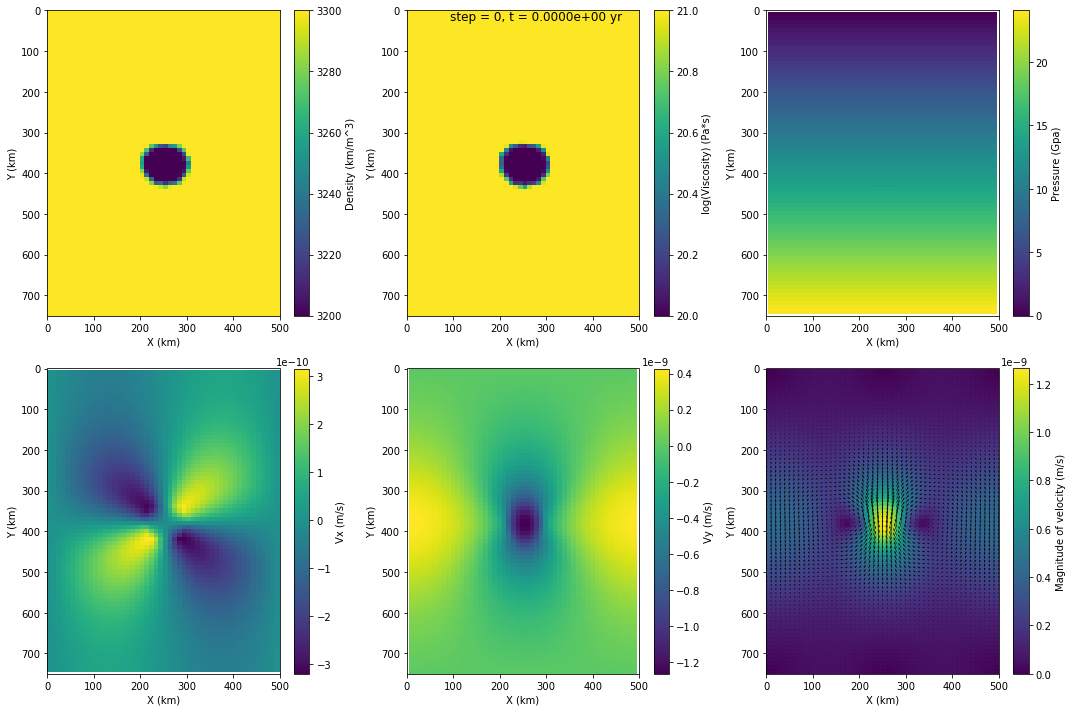

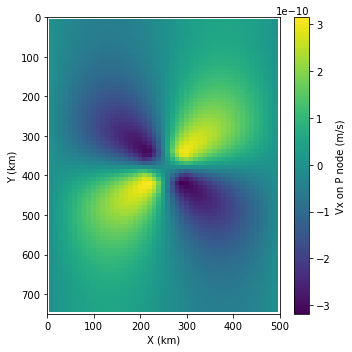

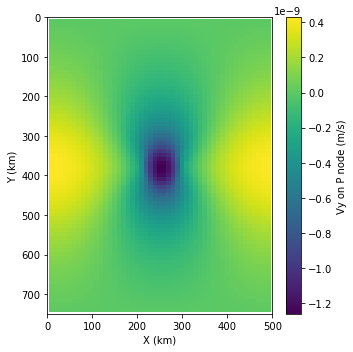

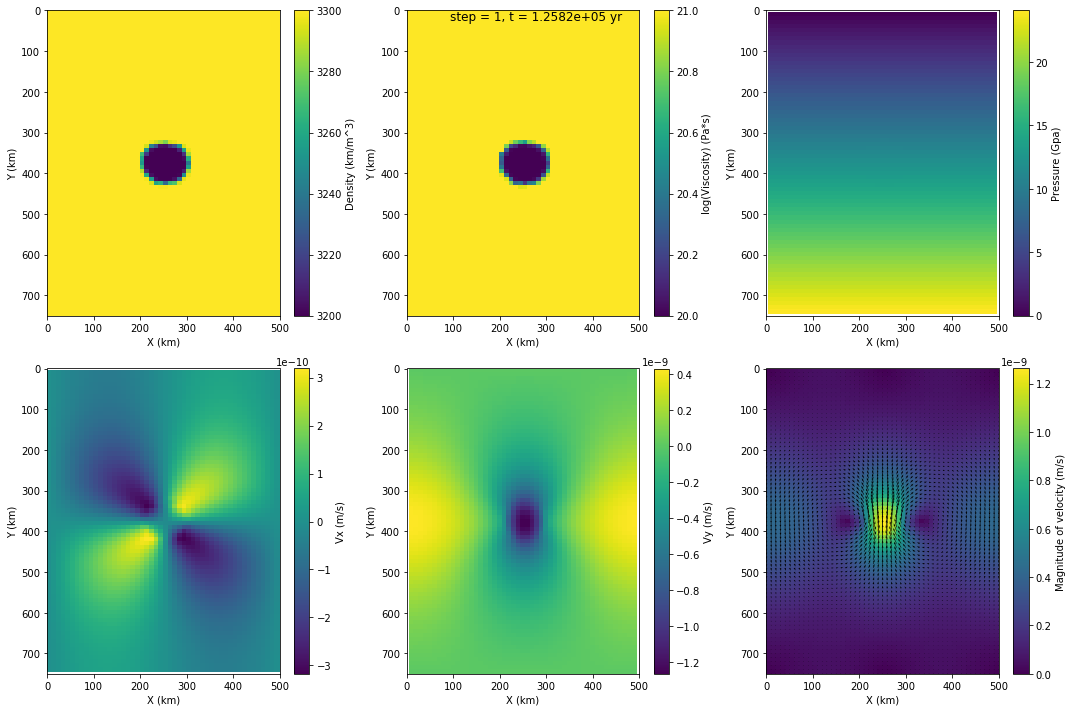

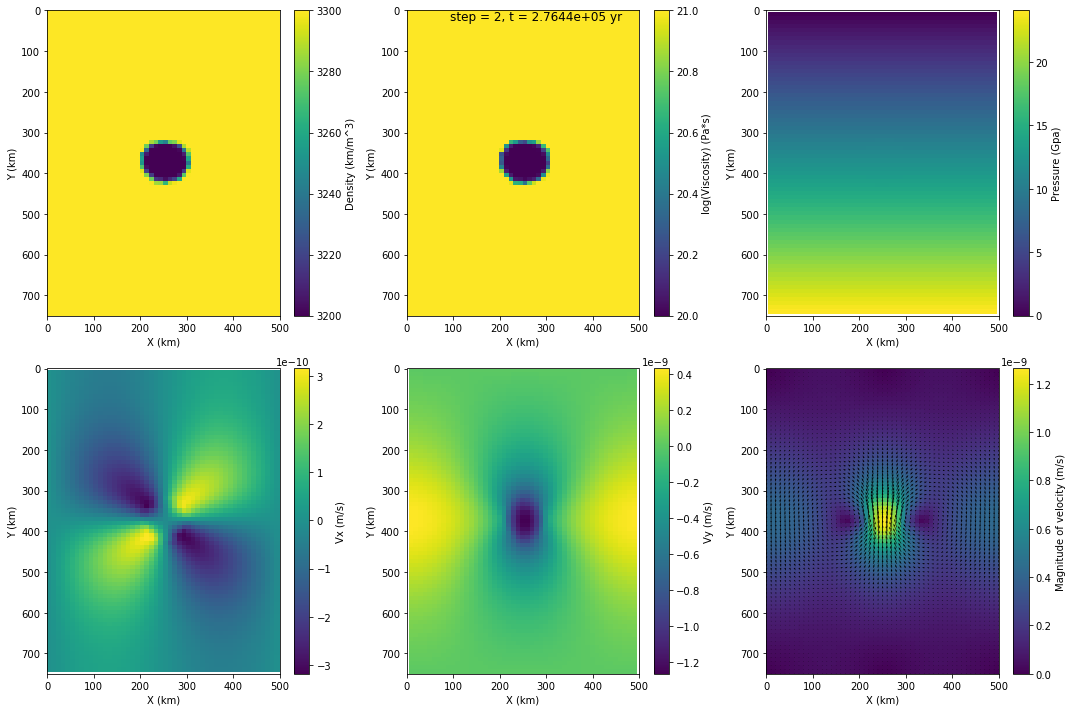

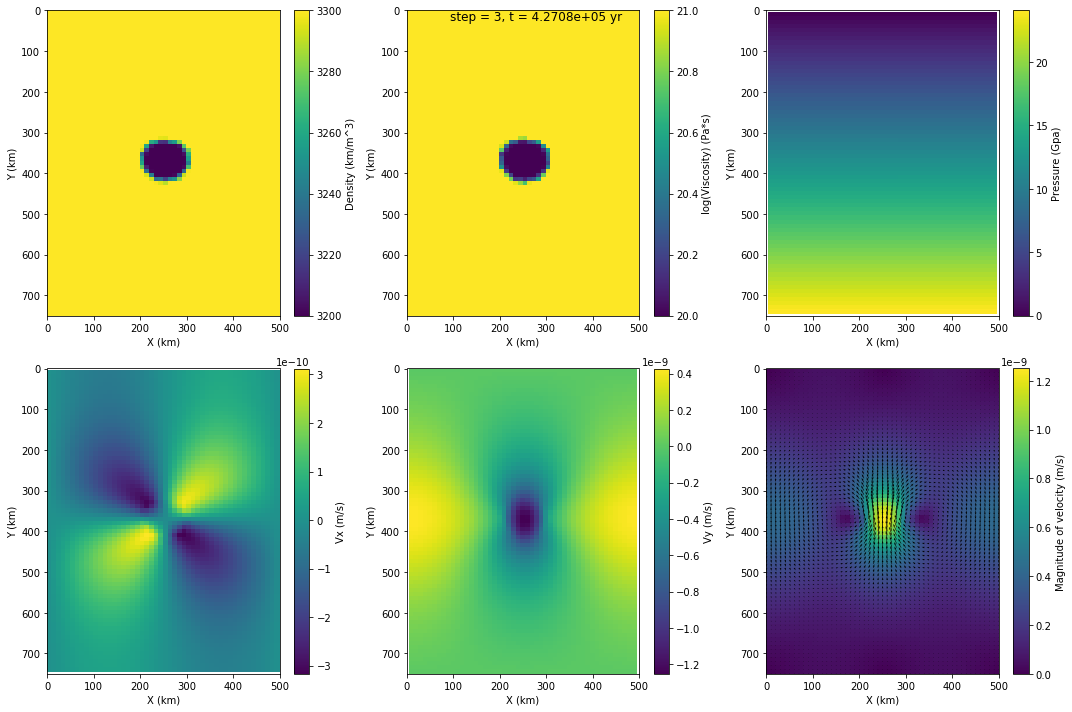

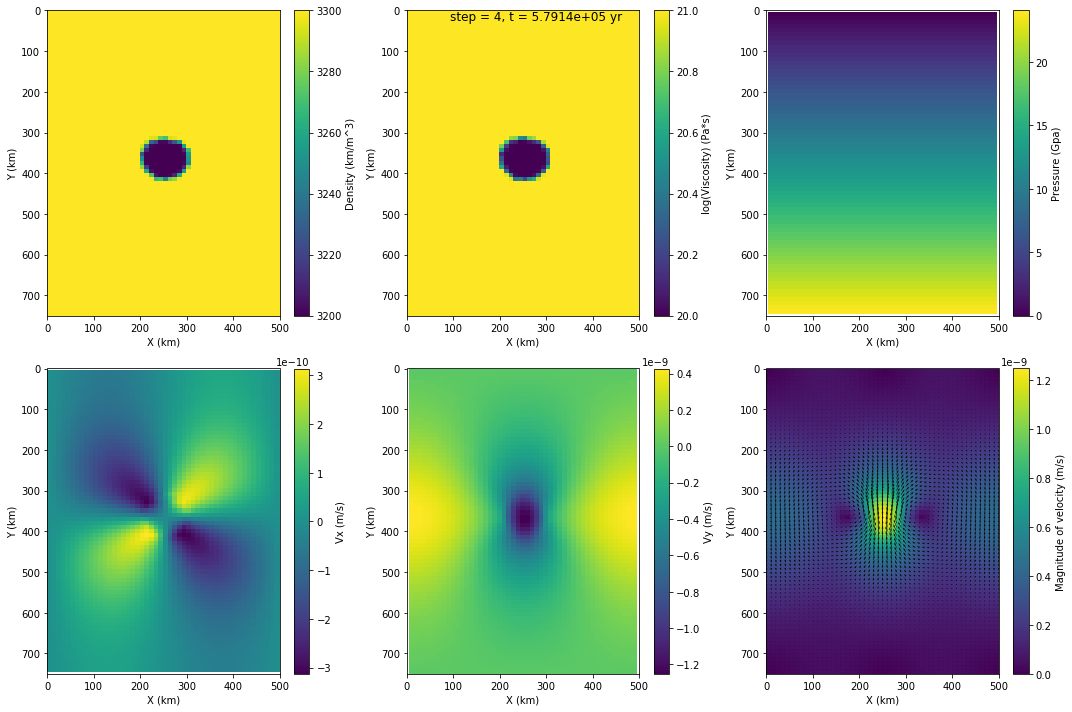

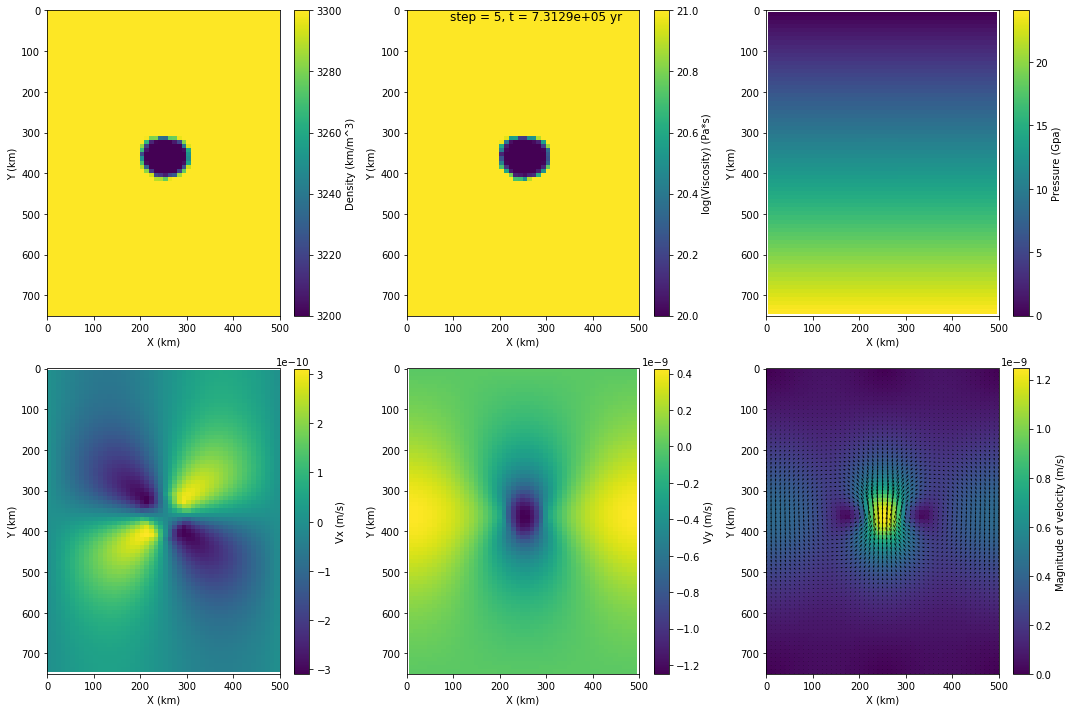

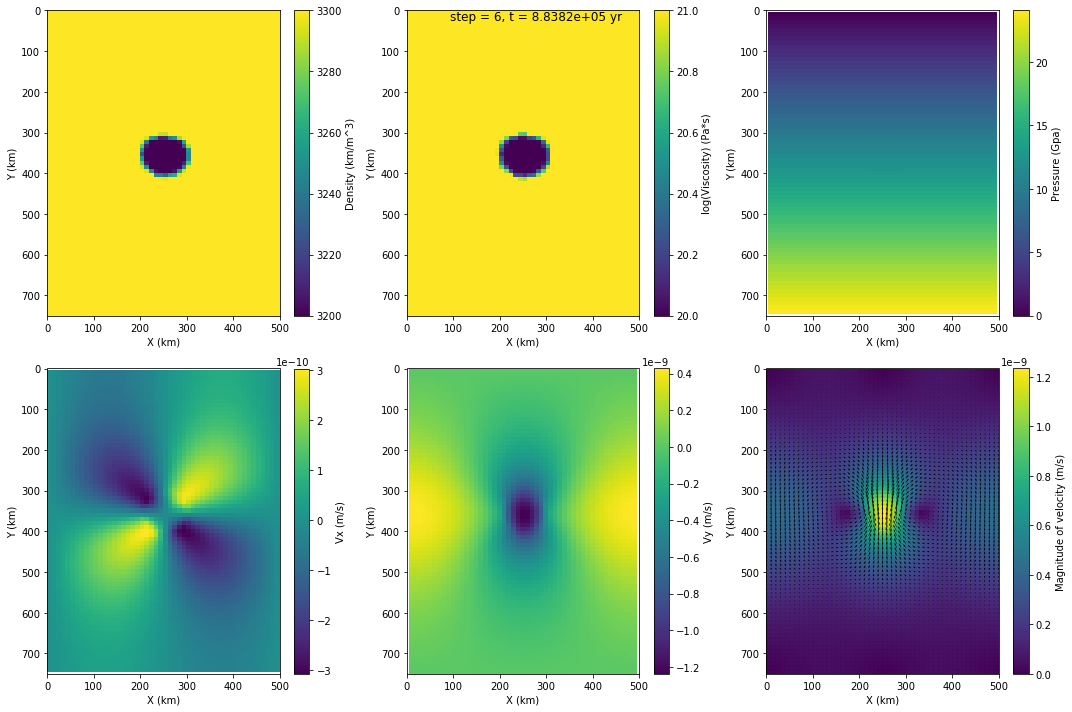

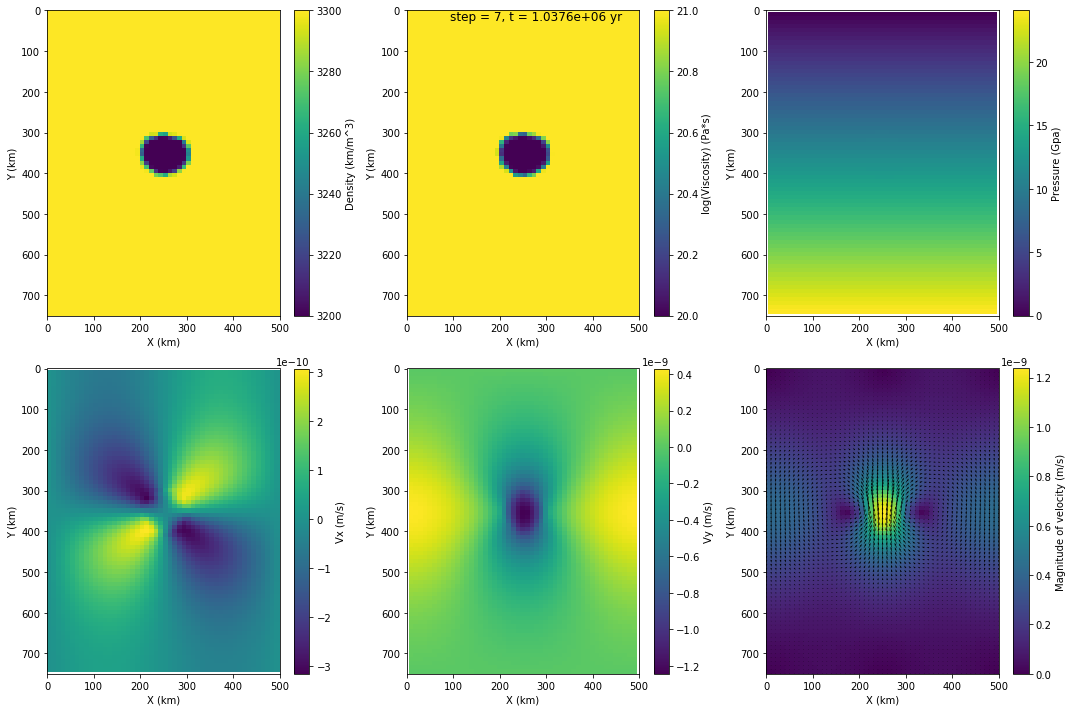

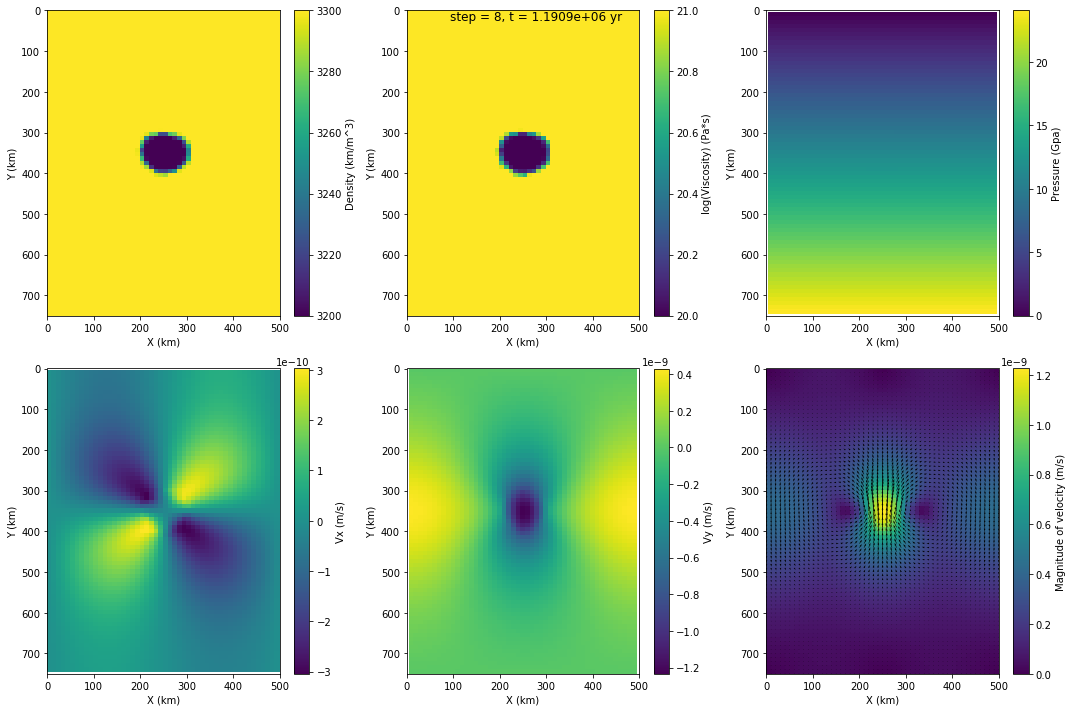

In [12]:
total_steps = 100 # total steps to solve
plot_per_step = 1  # plot every few steps
# assemble
print("Stokes_Continuity_Markers, step 0")
Solver.assemble()
Solver.solve()  # 0th step
plot_result(Mesh2d, Solver, Solver.MaterialModel)
# plot result of P velocity
plot_P_node_velocity(Solver)  # todo

# solve for subsequent steps
for step in range(1, total_steps):
    print("Stokes_Continuity_Markers, step %d" % step)
    Solver.advect()
    Solver.assemble()
    Solver.solve()  
    plot_result(Mesh2d, Solver, Solver.MaterialModel)